# Model notebook for Endless Line Eleven Strategy data challenge

## Useful imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
WAITING_PATH = 'data/waiting_times.csv'
LINK_PATH = 'data/link_attraction_park.csv'
ATTENDANCE_PATH = 'data/attendance.csv'
ENTITY_PATH = 'data/entity_schedule.csv'
WEATHER_PATH = 'data/weather_data.csv'
PARADE_PATH = 'data/parade_night_show.xlsx'

In [3]:
def join_and_clean(waiting_times_file, link_attraction_park_file, entity_schedule_file, attendance_file,
                    weather_file, parade_file):
    # Read waiting times dataframe
    df = pd.read_csv(waiting_times_file)

    # Read link attraction park dataframe
    park = pd.read_csv(link_attraction_park_file, sep=';')

    # Merge waiting times and park dataframes
    df = pd.merge(df, park, left_on='ENTITY_DESCRIPTION_SHORT', right_on='ATTRACTION')

    # Filter by park
    df = df[df.PARK == 'PortAventura World']

    # Drop unnecessary columns
    df.drop(columns=['ENTITY_DESCRIPTION_SHORT', 'PARK'], inplace=True)

    # Convert columns to datetime
    df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])
    df['FIN_TIME'] = pd.to_datetime(df['FIN_TIME'])
    df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])

    # Read entity schedule dataframe
    schedule = pd.read_csv(entity_schedule_file)

    # Convert columns to datetime
    schedule['DEB_TIME'] = pd.to_datetime(schedule['DEB_TIME'])
    schedule['FIN_TIME'] = pd.to_datetime(schedule['FIN_TIME'])
    schedule['WORK_DATE'] = pd.to_datetime(schedule['WORK_DATE'])

    # Get attractions open hours info
    schedule_attr = schedule[schedule.ENTITY_TYPE == 'ATTR']
    schedule_attr = schedule_attr.rename(columns={
        'DEB_TIME': 'DEB_TIME_ATTR',
        'FIN_TIME': 'FIN_TIME_ATTR',
        'REF_CLOSING_DESCRIPTION': 'REF_CLOSING_DESCRIPTION_ATTR'
    })

    # Merge attractions schedule with waiting times dataframe
    df = pd.merge(df, schedule_attr, how='left',
                  left_on=['WORK_DATE', 'ATTRACTION'],
                  right_on=['WORK_DATE', 'ENTITY_DESCRIPTION_SHORT'])

    # Drop unnecessary columns
    df = df.drop(columns=['ENTITY_DESCRIPTION_SHORT', 'ENTITY_TYPE', 'UPDATE_TIME'])

    # Get park open hours information
    schedule_park = schedule[schedule.ENTITY_TYPE == 'PARK']
    schedule_park = schedule_park[schedule_park['ENTITY_DESCRIPTION_SHORT'] == 'PortAventura World']
    schedule_park = schedule_park.rename(columns={
        'DEB_TIME': 'DEB_TIME_PARK',
        'FIN_TIME': 'FIN_TIME_PARK',
        'REF_CLOSING_DESCRIPTION': 'REF_CLOSING_DESCRIPTION_PARK'
    })

    # Group by work date and aggregate park schedule information
    schedule_park = schedule_park.groupby('WORK_DATE').agg({
        'DEB_TIME_PARK': 'min',
        'FIN_TIME_PARK': 'max',
        'REF_CLOSING_DESCRIPTION_PARK': 'first'
    }).reset_index()

    # Merge park schedule with waiting times dataframe
    df = pd.merge(df, schedule_park, how='left', on='WORK_DATE')

    # Read park attendance dataframe
    park_attendance = pd.read_csv(attendance_file)
    park_attendance = park_attendance[park_attendance.FACILITY_NAME == 'PortAventura World']
    park_attendance['USAGE_DATE'] = pd.to_datetime(park_attendance['USAGE_DATE'])
    park_attendance.drop(columns=['FACILITY_NAME'], inplace=True)

    # Merge attendance with waiting times dataframe
    df = pd.merge(df, park_attendance, how='left', left_on='WORK_DATE', right_on='USAGE_DATE')
    df.drop(columns=['USAGE_DATE'], inplace=True)
    df = df.rename(columns={'attendance': 'ATTENDANCE_PARK'})

    # Read weather data
    weather = pd.read_csv(weather_file)
    weather_sample = weather[['dt_iso', 'temp', 'wind_speed', 'weather_main']].copy()
    weather_sample['dt'] = weather_sample['dt_iso'].str[:19]
    #weather_sample.loc[:, 'dt'] = weather_sample[:, 'dt_iso'].str[:19].copy()
    weather_sample['dt'] = pd.to_datetime(weather_sample['dt'])
    weather_sample.drop(columns=['dt_iso'], inplace=True)

    # Create dataset with full datetime
    temp = pd.DataFrame()
    temp['DEB_TIME'] = df['DEB_TIME'].unique()

    # Add weather info
    datetime_weather = pd.merge(temp, weather_sample, how='left', left_on='DEB_TIME', right_on='dt')
    datetime_weather = datetime_weather.sort_values(by='DEB_TIME')

    # Fill NaNs with closest values
    datetime_weather['wind_speed'] = datetime_weather['wind_speed'].fillna(method='ffill')
    datetime_weather['weather_main'] = datetime_weather['weather_main'].fillna(method='ffill')
    datetime_weather['temp'] = datetime_weather['temp'].fillna(method='ffill')
    datetime_weather.drop(columns='dt', inplace=True)

    # Merge weather data with main dataframe
    df = pd.merge(df, datetime_weather, how='left', on='DEB_TIME')

    # Read parade data
    parade = pd.read_excel(parade_file, index_col=0)
    parade['PARADE_2'].fillna('12:10:00', inplace=True)

    # Format datetime
    parade['PARADE_1'] = parade['WORK_DATE'].astype(str) + ' ' + parade['PARADE_1'].astype(str)
    parade['PARADE_1'] = pd.to_datetime(parade['PARADE_1'])
    parade['PARADE_2'] = parade['WORK_DATE'].astype(str) + ' ' + parade['PARADE_2'].astype(str)
    parade['PARADE_2'] = pd.to_datetime(parade['PARADE_2'])
    parade['NIGHT_SHOW'] = parade['WORK_DATE'].astype(str) + ' ' + parade['NIGHT_SHOW'].astype(str)
    parade['NIGHT_SHOW'] = pd.to_datetime(parade['NIGHT_SHOW'])

    # Merge parade data with main dataframe
    df = pd.merge(df, parade, how='left', on='WORK_DATE')

    return df

In [4]:
df_merged = join_and_clean(WAITING_PATH, LINK_PATH, ENTITY_PATH, ATTENDANCE_PATH, WEATHER_PATH, PARADE_PATH)

In [34]:
df_merged.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT,ATTRACTION,REF_CLOSING_DESCRIPTION_ATTR,DEB_TIME_ATTR,FIN_TIME_ATTR,DEB_TIME_PARK,FIN_TIME_PARK,REF_CLOSING_DESCRIPTION_PARK,ATTENDANCE_PARK,temp,wind_speed,weather_main,NIGHT_SHOW,PARADE_1,PARADE_2,tso_attraction,tuc_attraction,tso_park,tuc_park,ts_last_parade,tu_next_parade
0,2018-01-01,2018-01-01 21:00:00,21,2018-01-01 21:15:00,0,2.0,0.0,0.0,0.0,0,0,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.80,7.58,Clouds,NaT,NaT,NaT,660.0,-196.0,750.0,60.0,NaN,NaN
1,2018-01-01,2018-01-01 15:00:00,15,2018-01-01 15:15:00,20,2.0,51.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,8.07,8.63,Rain,NaT,NaT,NaT,300.0,164.0,390.0,420.0,NaN,NaN
2,2018-01-01,2018-01-01 20:15:00,20,2018-01-01 20:30:00,0,2.0,0.0,0.0,0.0,0,0,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.44,7.96,Clouds,NaT,NaT,NaT,615.0,-151.0,705.0,105.0,NaN,NaN
3,2018-01-01,2018-01-01 11:45:00,11,2018-01-01 12:00:00,50,2.0,54.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.35,9.69,Rain,NaT,NaT,NaT,105.0,359.0,195.0,615.0,NaN,NaN
4,2018-01-01,2018-01-01 17:00:00,17,2018-01-01 17:15:00,20,2.0,29.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.76,9.77,Rain,NaT,NaT,NaT,420.0,44.0,510.0,300.0,NaN,NaN


In [35]:
df_merged.isna().sum()

WORK_DATE                             0
DEB_TIME                              0
DEB_TIME_HOUR                         0
FIN_TIME                              0
WAIT_TIME_MAX                         0
NB_UNITS                              0
GUEST_CARRIED                         0
CAPACITY                              0
ADJUST_CAPACITY                       0
OPEN_TIME                             0
UP_TIME                               0
DOWNTIME                              0
NB_MAX_UNIT                           0
ATTRACTION                            0
REF_CLOSING_DESCRIPTION_ATTR    2215559
DEB_TIME_ATTR                   1068927
FIN_TIME_ATTR                   1068927
DEB_TIME_PARK                   1067639
FIN_TIME_PARK                   1067639
REF_CLOSING_DESCRIPTION_PARK    2369821
ATTENDANCE_PARK                  713543
temp                                  0
wind_speed                            0
weather_main                          0
NIGHT_SHOW                      1427093


## Preprocessing and feature engineering

- Attendance
- Timeslot features
- Individual attraction features
- Relationship with other attractions 
- Interactions with other park events
- Weather

In [7]:
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1200x600 with 0 Axes>

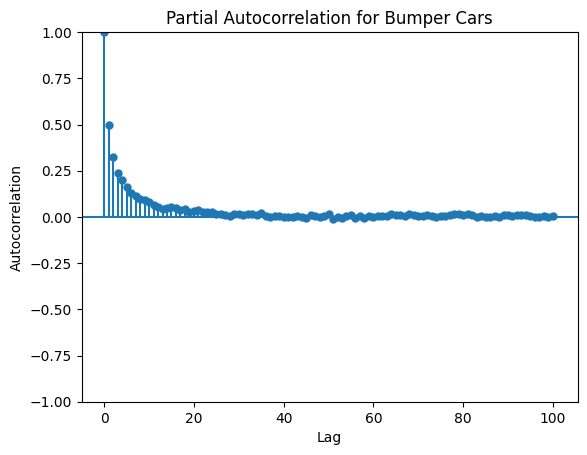

In [9]:
# Set the 'date' column as the index if it's not already
acf_data = df_merged[df_merged['ATTRACTION']=='Bumper Cars']
acf_data.set_index('DEB_TIME', inplace=True)

# Plot the autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(acf_data['WAIT_TIME_MAX'], lags=100, title='Partial Autocorrelation for Bumper Cars')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

<Figure size 1200x600 with 0 Axes>

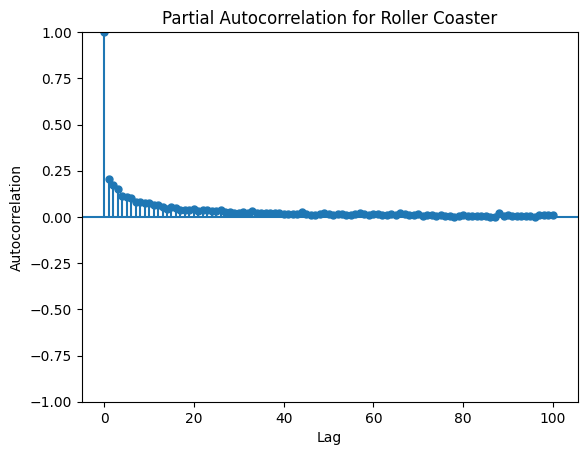

In [10]:
# Set the 'date' column as the index if it's not already
acf_data = df_merged[df_merged['ATTRACTION']=='Roller Coaster']
acf_data.set_index('DEB_TIME', inplace=True)

# Plot the autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(acf_data['WAIT_TIME_MAX'], lags=100, title='Partial Autocorrelation for Roller Coaster')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

In [11]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [12]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

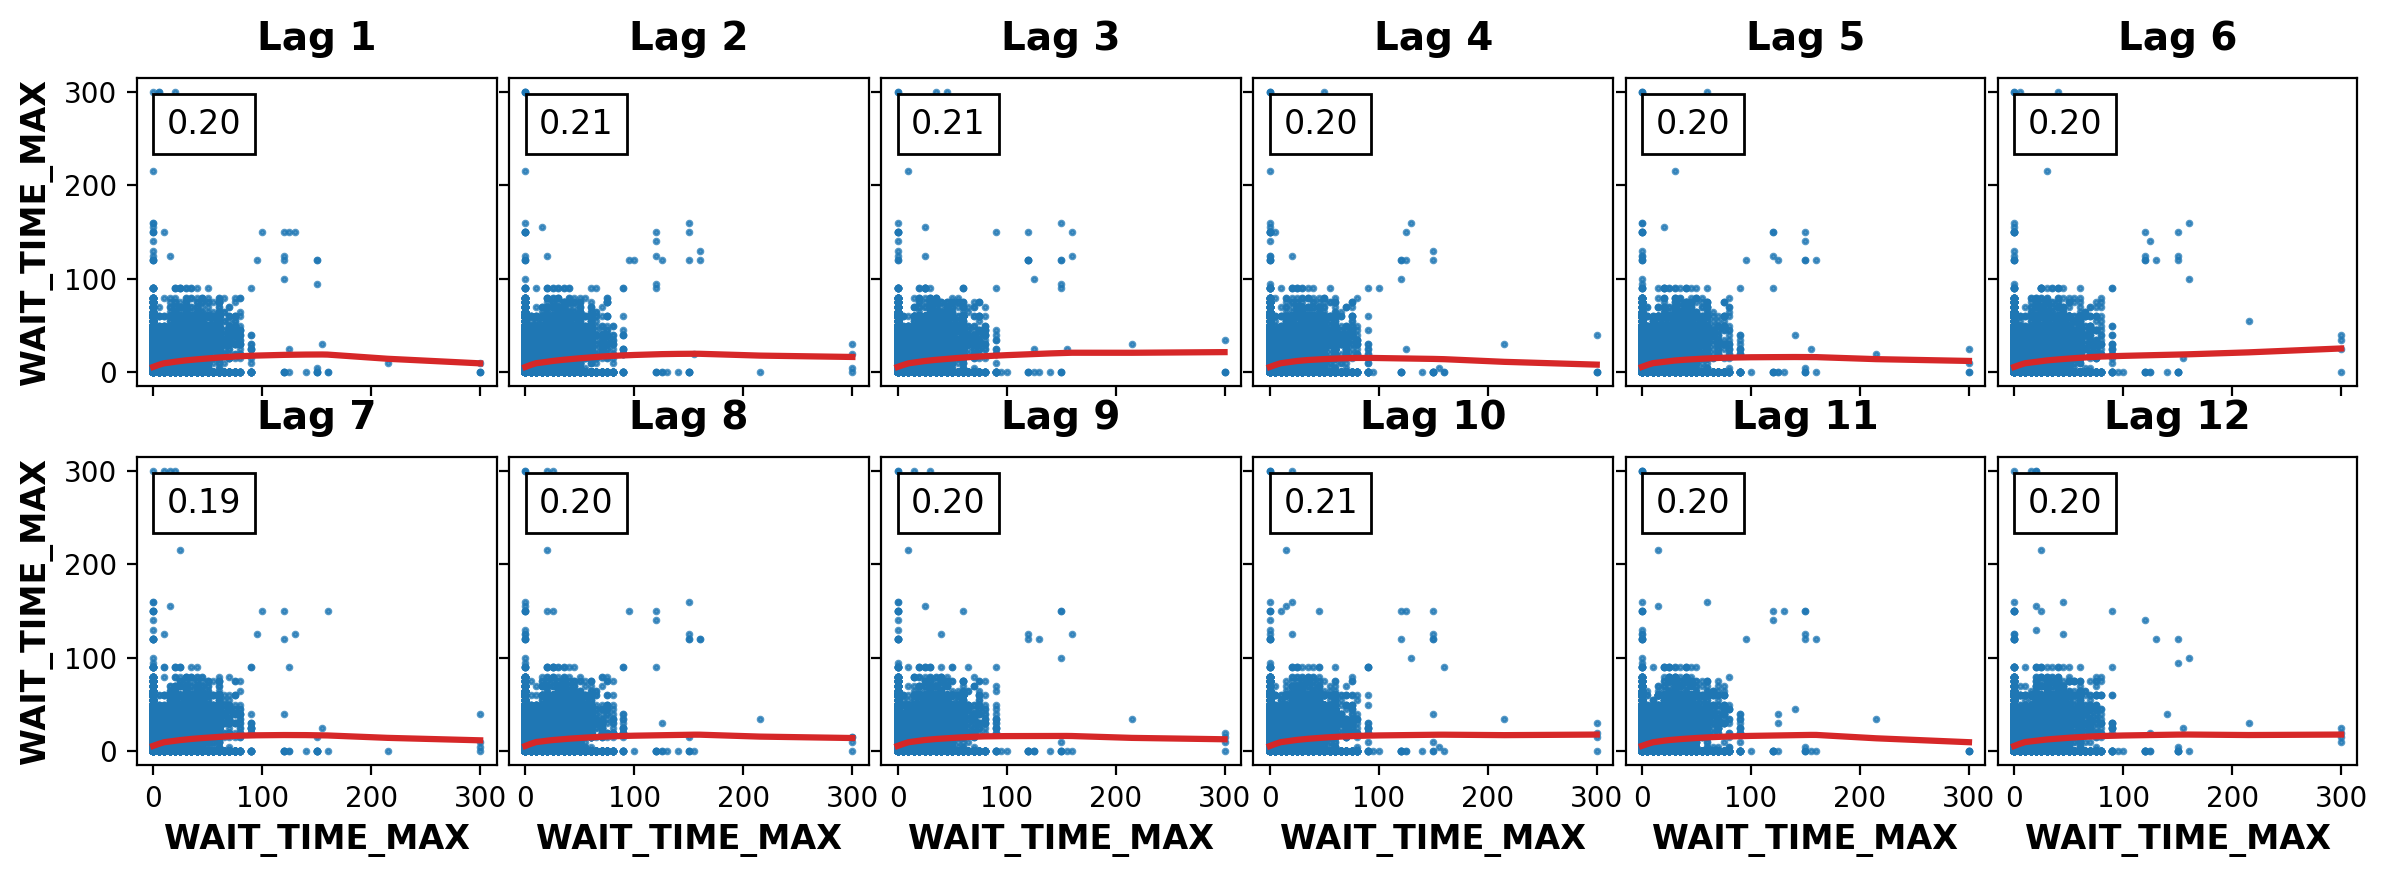

In [13]:
_ = plot_lags(df_merged[df_merged['ATTRACTION']=='Roller Coaster']['WAIT_TIME_MAX'], lags=12, nrows=2)

In [14]:
df_attendance = pd.read_csv(ATTENDANCE_PATH)
df_attendance = df_attendance[df_attendance['FACILITY_NAME']=='PortAventura World']
df_attendance['USAGE_DATE'] = pd.to_datetime(df_attendance['USAGE_DATE'])

fig = px.line(df_attendance, x='USAGE_DATE', y='attendance', markers=True, line_shape='linear',
              labels={'attendance': 'Attendance'},
              title='Evolution of ATTENDANCE_PARK over Time',
              template='plotly_dark')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Attendance')
fig.show()

### Building a forecasting model for the daily attendance (7 day horizon)

Daily attendance is surely the most important predictor of the waiting times. Lower global attendance will result in lower waiting times. In order to have the best forecast possible for each attraction, we will first build an individual model to predict the daily attendance in the park. 

In [36]:
df_attendance

,USAGE_DATE,FACILITY_NAME,attendance
0,2018-06-01,PortAventura World,46804
2,2018-06-02,PortAventura World,57940
4,2018-06-03,PortAventura World,44365
6,2018-06-04,PortAventura World,37617
8,2018-06-05,PortAventura World,32438
...,...,...,...
2357,2022-07-22,PortAventura World,49586
2359,2022-07-23,PortAventura World,51748
2361,2022-07-24,PortAventura World,45261
2363,2022-07-25,PortAventura World,53764


### Timeslot features

For each time slot, we calculate with regards to attraction and park the:
- Time since opening
- Time until closing

4 Features in total

In [15]:
def create_timeslot_features(df):
    # Calculate tso_attraction: how long the attraction has been open
    df['tso_attraction'] = (df['DEB_TIME'] - df['DEB_TIME_ATTR']).dt.total_seconds() / 60

    # Calculate tuc_attraction: how much time is left until the attraction closes
    df['tuc_attraction'] = (df['FIN_TIME_ATTR'] - df['DEB_TIME']).dt.total_seconds() / 60

    # Calculate tso_park: how long the park has been open
    df['tso_park'] = (df['DEB_TIME'] - df['DEB_TIME_PARK']).dt.total_seconds() / 60

    # Calculate tuc_park: how much time is left until the park closes
    df['tuc_park'] = (df['FIN_TIME_PARK'] - df['DEB_TIME']).dt.total_seconds() / 60

    return df

In [16]:
df_timeslot = create_timeslot_features(df_merged)
df_timeslot.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,...,temp,wind_speed,weather_main,NIGHT_SHOW,PARADE_1,PARADE_2,tso_attraction,tuc_attraction,tso_park,tuc_park
0,2018-01-01,2018-01-01 21:00:00,21,2018-01-01 21:15:00,0,2.0,0.0,0.0,0.0,0,...,6.80,7.58,Clouds,NaT,NaT,NaT,660.0,-196.0,750.0,60.0
1,2018-01-01,2018-01-01 15:00:00,15,2018-01-01 15:15:00,20,2.0,51.0,75.0,75.0,15,...,8.07,8.63,Rain,NaT,NaT,NaT,300.0,164.0,390.0,420.0
2,2018-01-01,2018-01-01 20:15:00,20,2018-01-01 20:30:00,0,2.0,0.0,0.0,0.0,0,...,7.44,7.96,Clouds,NaT,NaT,NaT,615.0,-151.0,705.0,105.0
3,2018-01-01,2018-01-01 11:45:00,11,2018-01-01 12:00:00,50,2.0,54.0,75.0,75.0,15,...,6.35,9.69,Rain,NaT,NaT,NaT,105.0,359.0,195.0,615.0
4,2018-01-01,2018-01-01 17:00:00,17,2018-01-01 17:15:00,20,2.0,29.0,75.0,75.0,15,...,7.76,9.77,Rain,NaT,NaT,NaT,420.0,44.0,510.0,300.0


### Individual attraction features

We want to find the best way to estimate in the future what is the "normal state" of a given attraction.

In [ ]:
# Extract day of the week and time of the day
data['day_of_week'] = data['date'].dt.day_name()
data['hour_of_day'] = data['date'].dt.hour

# Group by day of the week and calculate the mean for each hour
mean_by_day_hour = data.groupby(['day_of_week', 'hour_of_day'])['MW'].mean().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(mean_by_day_hour, cmap='BuPu', aspect='auto')
plt.colorbar(label='Mean MW')
plt.title('Correlation between Day of the Week and Time of the Day with MW')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(range(24), labels=range(24))
plt.yticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

In [ ]:
def create_attraction_features(df):
    return

### Relationship between attractions features

We aim at capturing the patterns between attractions.

In [17]:
pd.set_option('display.max_columns', None)
df_merged.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT,ATTRACTION,REF_CLOSING_DESCRIPTION_ATTR,DEB_TIME_ATTR,FIN_TIME_ATTR,DEB_TIME_PARK,FIN_TIME_PARK,REF_CLOSING_DESCRIPTION_PARK,ATTENDANCE_PARK,temp,wind_speed,weather_main,NIGHT_SHOW,PARADE_1,PARADE_2,tso_attraction,tuc_attraction,tso_park,tuc_park
0,2018-01-01,2018-01-01 21:00:00,21,2018-01-01 21:15:00,0,2.0,0.0,0.0,0.0,0,0,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.80,7.58,Clouds,NaT,NaT,NaT,660.0,-196.0,750.0,60.0
1,2018-01-01,2018-01-01 15:00:00,15,2018-01-01 15:15:00,20,2.0,51.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,8.07,8.63,Rain,NaT,NaT,NaT,300.0,164.0,390.0,420.0
2,2018-01-01,2018-01-01 20:15:00,20,2018-01-01 20:30:00,0,2.0,0.0,0.0,0.0,0,0,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.44,7.96,Clouds,NaT,NaT,NaT,615.0,-151.0,705.0,105.0
3,2018-01-01,2018-01-01 11:45:00,11,2018-01-01 12:00:00,50,2.0,54.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.35,9.69,Rain,NaT,NaT,NaT,105.0,359.0,195.0,615.0
4,2018-01-01,2018-01-01 17:00:00,17,2018-01-01 17:15:00,20,2.0,29.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.76,9.77,Rain,NaT,NaT,NaT,420.0,44.0,510.0,300.0


### Interactions with other park events

These features aim at translating potential behaviours of clients related to activites that are not attractions within the park (e.g. parades).
- Time since last parade
- Time until next parade

2 features

In [24]:
def create_interaction_features(df):
    # Find the time since the last parade (ts_last_parade)
    parade_times = ['PARADE_1', 'PARADE_2', 'NIGHT_SHOW']

    for parade_time in parade_times:
        df[f'ts_last_{parade_time}'] = (df['DEB_TIME'] - df[parade_time]).dt.total_seconds() / 60  # in minutes

    # Find the minimum positive time since the last parade
    positive_times_last = df.filter(like='ts_last', axis=1)
    df['ts_last_parade'] = positive_times_last[positive_times_last > 0].min(axis=1)

    # Drop intermediate columns
    df.drop(columns=[f'ts_last_{parade_time}' for parade_time in parade_times], inplace=True)

    # Find the time until the next parade (tu_next_parade)
    for parade_time in parade_times:
        df[f'tu_next_{parade_time}'] = (df[parade_time] - df['DEB_TIME']).dt.total_seconds() / 60  # in minutes

    # Find the minimum positive time until the next parade
    positive_times_next = df.filter(like='tu_next', axis=1)
    df['tu_next_parade'] = positive_times_next[positive_times_next > 0].min(axis=1)

    # Drop intermediate columns
    df.drop(columns=[f'tu_next_{parade_time}' for parade_time in parade_times], inplace=True)

    return df

### Weather features

Weather conditions highly influence the way clients behave inside the theme park. If the weather is bad, they will more likely resort to indoors activities (shops, restaurants) and more protected attractions.
<br>
With these features, we want to capture broad weather trends (temperature from the past years at the same period, main weather probabilities) and update them with the latest weather observed (i.e. a week before forecasting).

Features based on weather in the past years within a 2 week interval surrounding the date.
- proba_cloud_past
- proba_rain_past
- proba_clear_past
- proba_snow_past
- temp_mean_past
- temp_1quartile_past
- temp_3quartile_past

Features based on recent weather (calculated on the latest week of data available)
- proba_cloud_present
- proba_rain_present
- proba_clear_present
- proba_snow_present
- temp_mean_present
- temp_1quartile_present
- temp_3quartile_present


In [27]:
df_weather = pd.read_csv(WEATHER_PATH)
df_weather.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,915148800,1999-01-01 00:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,8.33,NaN,3.39,5.28,8.14,9.32,1006,NaN,NaN,71,5.57,152,NaN,NaN,NaN,NaN,NaN,8,800,Clear,sky is clear,01n
1,915152400,1999-01-01 01:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,8.08,NaN,3.54,5.18,7.94,9.32,1006,NaN,NaN,73,5.02,153,NaN,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n
2,915156000,1999-01-01 02:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,8.08,NaN,4.11,5.38,7.94,8.74,1006,NaN,NaN,76,4.56,153,NaN,NaN,NaN,NaN,NaN,14,801,Clouds,few clouds,02n
3,915159600,1999-01-01 03:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,7.31,NaN,3.73,4.42,7.14,8.62,1006,NaN,NaN,78,4.56,154,NaN,NaN,NaN,NaN,NaN,39,802,Clouds,scattered clouds,03n
4,915163200,1999-01-01 04:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,6.91,NaN,3.53,4.00,6.74,8.32,1007,NaN,NaN,79,4.40,159,NaN,NaN,NaN,NaN,NaN,52,803,Clouds,broken clouds,04n


In [39]:
df_weather['dt'] = pd.to_datetime(df_weather['dt_iso'].str[:19])

In [41]:
df_weather.weather_main.unique()

array(['Clear', 'Clouds', 'Rain', 'Snow'], dtype=object)

In [44]:
import pandas as pd
import numpy as np

def calculate_weather_stats(df_weather):
    # Sort the dataframe by the 'dt' column
    df_weather = df_weather.sort_values(by='dt')

    # Define a function to calculate quartiles
    def calculate_quartiles(series):
        return np.percentile(series, [25, 75])

    # Define a function to calculate probabilities
    def calculate_probabilities(series, value):
        return (series == value).mean()

    # Calculate the statistics for each day
    result = []
    for i in range(len(df_weather)):
        current_date = df_weather.iloc[i]['dt']
        start_date = current_date - pd.DateOffset(weeks=53)
        end_date = current_date - pd.DateOffset(weeks=51)

        # Filter the dataframe for the specified date range
        selected_data = df_weather[(df_weather['dt'] >= start_date) & (df_weather['dt'] <= end_date)]

        # Skip if selected_data is empty
        if selected_data.empty:
            continue

        # Calculate probabilities
        proba_cloud_past = calculate_probabilities(selected_data['weather_main'], 'Clouds')
        proba_rain_past = calculate_probabilities(selected_data['weather_main'], 'Rain')
        proba_clear_past = calculate_probabilities(selected_data['weather_main'], 'Clear')
        proba_snow_past = calculate_probabilities(selected_data['weather_main'], 'Snow')

        # Calculate temperature statistics
        temp_mean_past = selected_data['temp'].mean()
        temp_quartiles_past = calculate_quartiles(selected_data['temp'])
        temp_1quartile_past, temp_3quartile_past = temp_quartiles_past

        # Append the results for the current date
        result.append({
            'dt': current_date,
            'proba_cloud_past': proba_cloud_past,
            'proba_rain_past': proba_rain_past,
            'proba_clear_past': proba_clear_past,
            'proba_snow_past': proba_snow_past,
            'temp_mean_past': temp_mean_past,
            'temp_1quartile_past': temp_1quartile_past,
            'temp_3quartile_past': temp_3quartile_past
        })

    # Create a new dataframe from the results
    result_df = pd.DataFrame(result)

    return result_df


In [45]:
# Assuming df_weather is your original dataframe
result_df = calculate_weather_stats(df_weather)
result_df

,dt,proba_cloud_past,proba_rain_past,proba_clear_past,proba_snow_past,temp_mean_past,temp_1quartile_past,temp_3quartile_past
0,1999-12-24 00:00:00,0.000000,0.000000,1.000000,0.0,8.330000,8.3300,8.3300
1,1999-12-24 01:00:00,0.000000,0.000000,1.000000,0.0,8.205000,8.1425,8.2675
2,1999-12-24 02:00:00,0.333333,0.000000,0.666667,0.0,8.163333,8.0800,8.2050
3,1999-12-24 03:00:00,0.500000,0.000000,0.500000,0.0,7.950000,7.8875,8.1425
4,1999-12-24 04:00:00,0.600000,0.000000,0.400000,0.0,7.742000,7.3100,8.0800
...,...,...,...,...,...,...,...,...
198691,2022-08-23 19:00:00,0.824926,0.083086,0.091988,0.0,17.696825,15.5900,19.7800
198692,2022-08-23 20:00:00,0.821958,0.083086,0.094955,0.0,17.697211,15.5900,19.7800
198693,2022-08-23 21:00:00,0.818991,0.083086,0.097923,0.0,17.695519,15.5900,19.7800
198694,2022-08-23 22:00:00,0.816024,0.083086,0.100890,0.0,17.694243,15.5900,19.7800


## Choosing candidate models

In [15]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## Evaluate the performance and fine-tune

## Explainability

In [48]:
df_merged.columns

Index(['WORK_DATE', 'DEB_TIME', 'DEB_TIME_HOUR', 'FIN_TIME', 'WAIT_TIME_MAX',
       'NB_UNITS', 'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY', 'OPEN_TIME',
       'UP_TIME', 'DOWNTIME', 'NB_MAX_UNIT', 'ATTRACTION',
       'REF_CLOSING_DESCRIPTION_ATTR', 'DEB_TIME_ATTR', 'FIN_TIME_ATTR',
       'DEB_TIME_PARK', 'FIN_TIME_PARK', 'REF_CLOSING_DESCRIPTION_PARK',
       'ATTENDANCE_PARK'],
      dtype='object')

In [57]:

latest_timestamp = df_merged['DEB_TIME'].max()
one_year_ago = latest_timestamp - pd.DateOffset(years=1)

# Group by date and take the first line to get unique attendance values for each date
df_last_year = df_merged[df_merged['DEB_TIME'] >= one_year_ago]

In [58]:
# Question 1: Number of visitors on the last year of data
# Group by date and take the first line to get unique attendance values for each date
attendance_last_year = df_last_year.groupby('WORK_DATE')['ATTENDANCE_PARK'].first()
total_visitors_last_year = attendance_last_year.sum()

print("Number of visitors on the last year of data:", total_visitors_last_year)


Number of visitors on the last year of data: 11379861.0


In [61]:
# Question 2: Sum of guest_carried across all attractions per visitor daily
daily_guest_carried_sum = df_last_year.groupby(['WORK_DATE'])['GUEST_CARRIED'].sum().mean()
print("Average number of rides daily:", daily_guest_carried_sum)

print(f'Average number of rides per guest daily: {daily_guest_carried_sum*365/total_visitors_last_year}')

Average number of rides daily: 149340.83988907104
Average number of rides per guest daily: 4.789988784530051


In [64]:
# Question 3: Average waiting time per attraction
average_waiting_time_per_attraction = df_last_year.groupby('ATTRACTION')['WAIT_TIME_MAX'].mean()
print(f"Average waiting time per attraction:{average_waiting_time_per_attraction}")

average_waiting_time = df_last_year['WAIT_TIME_MAX'].mean()
print(f"Average waiting time:{average_waiting_time}")

Average waiting time per attraction:ATTRACTION
Bumper Cars          8.929830
Bungee Jump         17.246441
Circus Train         4.099271
Crazy Dance          2.282763
Dizzy Dropper       12.084740
Drop Tower          26.189509
Flying Coaster      15.027154
Free Fall           32.917747
Giant Wheel         35.167327
Giga Coaster         2.260267
Go-Karts            27.416577
Haunted House       17.083476
Himalaya Ride        0.000000
Inverted Coaster    11.534867
Kiddie Coaster       6.248348
Merry Go Round      14.683662
Oz Theatre           4.268096
Rapids Ride         12.985860
Roller Coaster      15.312729
Spinning Coaster    19.169643
Spiral Slide        29.418531
Superman Ride        7.458523
Swing Ride          37.419008
Vertical Drop        9.968434
Water Ride          21.305539
Zipline             22.726450
Name: WAIT_TIME_MAX, dtype: float64
Average waiting time:16.08274965911872
